<a href="https://colab.research.google.com/github/faiyaz106/Thermal-facial-landmark-detection/blob/main/train_MobileNetV2_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!nvidia-smi

Sun Jul 16 19:58:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Loading the data from google drive (By mounting google drive )
from google.colab import drive
drive.mount("/thermal",force_remount=True)

Mounted at /thermal


In [9]:
# import the necessary packages
from imutils import paths
import imutils
import json
import time
import cv2
import os
import math
import numpy as np
import pandas as pd

import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
#from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

#from test_utils import summary, comparator
#import public_tests

%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)



```
# This is formatted as code
```

### Loading Dataset

In [10]:
# function to correct landmarks' order after mirroring

def correct_landmarks_order(pts_mirr):
    # pts_mirr - list of landmarks for one face

	pts_mirr_c = []

	# chin
	pts_mirr_c.append(pts_mirr[16])
	pts_mirr_c.append(pts_mirr[15])
	pts_mirr_c.append(pts_mirr[14])
	pts_mirr_c.append(pts_mirr[13])
	pts_mirr_c.append(pts_mirr[12])
	pts_mirr_c.append(pts_mirr[11])
	pts_mirr_c.append(pts_mirr[10])
	pts_mirr_c.append(pts_mirr[9])
	pts_mirr_c.append(pts_mirr[8])
	pts_mirr_c.append(pts_mirr[7])
	pts_mirr_c.append(pts_mirr[6])
	pts_mirr_c.append(pts_mirr[5])
	pts_mirr_c.append(pts_mirr[4])
	pts_mirr_c.append(pts_mirr[3])
	pts_mirr_c.append(pts_mirr[2])
	pts_mirr_c.append(pts_mirr[1])
	pts_mirr_c.append(pts_mirr[0])

	# left eyebrow
	pts_mirr_c.append(pts_mirr[26])
	pts_mirr_c.append(pts_mirr[25])
	pts_mirr_c.append(pts_mirr[24])
	pts_mirr_c.append(pts_mirr[23])
	pts_mirr_c.append(pts_mirr[22])

	# right eyebrow
	pts_mirr_c.append(pts_mirr[21])
	pts_mirr_c.append(pts_mirr[20])
	pts_mirr_c.append(pts_mirr[19])
	pts_mirr_c.append(pts_mirr[18])
	pts_mirr_c.append(pts_mirr[17])

	# nose bridge
	pts_mirr_c.append(pts_mirr[27])
	pts_mirr_c.append(pts_mirr[28])
	pts_mirr_c.append(pts_mirr[29])
	pts_mirr_c.append(pts_mirr[30])

	# nose tip
	pts_mirr_c.append(pts_mirr[35])
	pts_mirr_c.append(pts_mirr[34])
	pts_mirr_c.append(pts_mirr[33])
	pts_mirr_c.append(pts_mirr[32])
	pts_mirr_c.append(pts_mirr[31])

	# left eye
	pts_mirr_c.append(pts_mirr[45])
	pts_mirr_c.append(pts_mirr[44])
	pts_mirr_c.append(pts_mirr[43])
	pts_mirr_c.append(pts_mirr[42])
	pts_mirr_c.append(pts_mirr[47])
	pts_mirr_c.append(pts_mirr[46])

	# right eye
	pts_mirr_c.append(pts_mirr[39])
	pts_mirr_c.append(pts_mirr[38])
	pts_mirr_c.append(pts_mirr[37])
	pts_mirr_c.append(pts_mirr[36])
	pts_mirr_c.append(pts_mirr[41])
	pts_mirr_c.append(pts_mirr[40])

	# lips
	pts_mirr_c.append(pts_mirr[50])
	pts_mirr_c.append(pts_mirr[49])
	pts_mirr_c.append(pts_mirr[48])
	pts_mirr_c.append(pts_mirr[51])
	pts_mirr_c.append(pts_mirr[52])
	pts_mirr_c.append(pts_mirr[53])

	return pts_mirr_c

In [11]:
# path to the dataset
datasetPath = '/thermal/MyDrive/dataset'
# datasetPath='/dataset'

# original image size and intended image size
H = 512
W = 640

h = 256
w = 256

# number of facial landmarks
KEYPOINTS = 54

In [12]:
# function to import dataset
def import_data(t,s):
    # s - train / val / test
    # t- gray/iron/arrays
    # list to store imported data
    images = []
    annotations =[]
    #a,b,c,d=[],[],[],[]
    extn_map={"arrays":'.npy',"gray":'.jpg',"iron":'.png'}
    # extract paths to json files
    # we use grayscaled images for landmark prediction
    #jsonFolder = os.path.join(datasetPath, "gray", s, 'json')
    #jsonPaths = list(paths.list_files(jsonFolder, validExts="json"))
    #jsonPaths = sorted(jsonPaths)
    #datesetPath='/thermal/MyDrive/dataset'
    labelsFolder=os.path.join(datasetPath,s)
    #labelsFolder='/thermal/MyDrive/dataset'
    txtPaths = list(paths.list_files(labelsFolder, validExts="txt"))
    txtPaths = sorted(txtPaths)

    # loop over the json files
    for ind, txtPath in enumerate(txtPaths, 1):

        print("[INFO] Processing {} file ({}/{})".format(txtPath.split("/")[-1], ind, len(txtPaths)))

        # opening the text file
        f = open(txtPath,)
        f=f.readlines()

        # loading the image and converting it to grayscale
        if t=="gray":
          imagePath = txtPath.replace('labels',t)
          imagePath = imagePath.replace('.txt', '.jpg')
          image = cv2.imread(imagePath)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if t=="iron":
          imagePath = txtPath.replace('labels',t)
          imagePath = imagePath.replace('.txt', '.png')
          image = cv2.imread(imagePath)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if t=="arrays":
          imagePath = txtPath.replace('labels',t)
          imagePath = imagePath.replace('.txt', '.npy')
          image=np.load(imagePath)
          #image = cv2.imread(imagePath)
          #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # iterating through the shapes
        landmarks = []
        # resize the image, normalize
        crop_image = cv2.resize(image, (w, h) )
        crop_image = crop_image.astype('float32')
        crop_image = crop_image / 255.0

        # mirror the processed image
        crop_image_flip = cv2.flip(crop_image, flipCode=1)

        for point in f:
            point=point.split(' ')
            x=point[1]
            y=point[2]
            (x,y)=(float(x),float(y))
            (x_re,y_re)=(x, y)
            landmarks.append([y_re,x_re])
        landmarks = np.array(landmarks)
        # mirror the landmarks
        landmarks_mirr = landmarks.copy()
        landmarks_mirr[:,1] = 1 - landmarks_mirr[:,1]
        landmarks_mirr = correct_landmarks_order(landmarks_mirr.tolist())

        # flatten the landmarks
        landmarks = landmarks.flatten()
        landmarks_mirr = np.array(landmarks_mirr).flatten()

        # store imported and processed data
        images.append(crop_image)
        annotations.append(landmarks)

        images.append(crop_image_flip)
        annotations.append(landmarks_mirr)
        #a.append(crop_image.shape)
        #a.append(crop_image_flip.shape)
        #b.append(landmarks.shape)
        #b.append(landmarks.shape)
        #c.append(mask.shape)
        #c.append(mask_mirr.shape)
        #d.append(txtPath)
        #d.append(txtPath)
    # converting to numpy arrays
    # expanding image dimensions from (N, h, w) to (N, h, w, 1)
    images = np.expand_dims(np.array(images), axis = 3)
    annotations = np.array(annotations)


    return images, annotations

In [13]:
#Preparing Training set
img_train,l_train=import_data('gray','train')

[INFO] Processing 100_2106.txt file (1/3400)
[INFO] Processing 100_2140.txt file (2/3400)
[INFO] Processing 100_2397.txt file (3/3400)
[INFO] Processing 100_3014.txt file (4/3400)
[INFO] Processing 100_3054.txt file (5/3400)
[INFO] Processing 100_3163.txt file (6/3400)
[INFO] Processing 100_3577.txt file (7/3400)
[INFO] Processing 100_3654.txt file (8/3400)
[INFO] Processing 100_4183.txt file (9/3400)
[INFO] Processing 100_4283.txt file (10/3400)
[INFO] Processing 100_4331.txt file (11/3400)
[INFO] Processing 100_4385.txt file (12/3400)
[INFO] Processing 100_4589.txt file (13/3400)
[INFO] Processing 100_4603.txt file (14/3400)
[INFO] Processing 100_4708.txt file (15/3400)
[INFO] Processing 100_4764.txt file (16/3400)
[INFO] Processing 100_4810.txt file (17/3400)
[INFO] Processing 100_4814.txt file (18/3400)
[INFO] Processing 100_5029.txt file (19/3400)
[INFO] Processing 100_5114.txt file (20/3400)
[INFO] Processing 100_5322.txt file (21/3400)
[INFO] Processing 100_5328.txt file (22/340

In [14]:
# Preparing Validation set
img_val,l_val=import_data('gray','val')

[INFO] Processing 115_2135.txt file (1/750)
[INFO] Processing 115_2361.txt file (2/750)
[INFO] Processing 115_2465.txt file (3/750)
[INFO] Processing 115_2615.txt file (4/750)
[INFO] Processing 115_2763.txt file (5/750)
[INFO] Processing 115_2968.txt file (6/750)
[INFO] Processing 115_3195.txt file (7/750)
[INFO] Processing 115_3517.txt file (8/750)
[INFO] Processing 115_3581.txt file (9/750)
[INFO] Processing 115_3587.txt file (10/750)
[INFO] Processing 115_3654.txt file (11/750)
[INFO] Processing 115_3758.txt file (12/750)
[INFO] Processing 115_4098.txt file (13/750)
[INFO] Processing 115_4139.txt file (14/750)
[INFO] Processing 115_4251.txt file (15/750)
[INFO] Processing 115_4314.txt file (16/750)
[INFO] Processing 115_4435.txt file (17/750)
[INFO] Processing 115_4537.txt file (18/750)
[INFO] Processing 115_4754.txt file (19/750)
[INFO] Processing 115_4897.txt file (20/750)
[INFO] Processing 115_5344.txt file (21/750)
[INFO] Processing 115_5385.txt file (22/750)
[INFO] Processing 1

In [15]:
# Preparing test set
img_test,l_test=import_data('gray','test')

[INFO] Processing 140_2141.txt file (1/900)
[INFO] Processing 140_2250.txt file (2/900)
[INFO] Processing 140_2299.txt file (3/900)
[INFO] Processing 140_2534.txt file (4/900)
[INFO] Processing 140_2564.txt file (5/900)
[INFO] Processing 140_2685.txt file (6/900)
[INFO] Processing 140_3181.txt file (7/900)
[INFO] Processing 140_3562.txt file (8/900)
[INFO] Processing 140_3703.txt file (9/900)
[INFO] Processing 140_3961.txt file (10/900)
[INFO] Processing 140_3966.txt file (11/900)
[INFO] Processing 140_4056.txt file (12/900)
[INFO] Processing 140_4218.txt file (13/900)
[INFO] Processing 140_4326.txt file (14/900)
[INFO] Processing 140_4647.txt file (15/900)
[INFO] Processing 140_4986.txt file (16/900)
[INFO] Processing 140_5049.txt file (17/900)
[INFO] Processing 140_5097.txt file (18/900)
[INFO] Processing 140_5157.txt file (19/900)
[INFO] Processing 140_5170.txt file (20/900)
[INFO] Processing 140_5341.txt file (21/900)
[INFO] Processing 140_5472.txt file (22/900)
[INFO] Processing 1

In [16]:
# sanity check
print(img_train.shape)
print(l_train.shape)
print(img_val.shape)
print(l_val.shape)
print(img_test.shape)
print(l_test.shape)

(6800, 256, 256, 1)
(6800, 108)
(1500, 256, 256, 1)
(1500, 108)
(1800, 256, 256, 1)
(1800, 108)


### Model ( MobileNetV2)
# Reference
- [Inverted Residuals and Linear Bottlenecks Mobile Networks for
   Classification, Detection and Segmentation]
   (https://arxiv.org/abs/1801.04381)


In [17]:
# Define ReLU6 activation
relu6 = tf.keras.layers.ReLU(6.)

def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.

    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.

    # Returns
        Output tensor.
    """

    x = tf.keras.layers.Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    return relu6(x)


In [18]:
def _bottleneck(inputs, filters, kernel, t, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.

    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.

    # Returns
        Output tensor.
    """

    tchannel = inputs.shape[-1] * t

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = relu6(x)

    x = tf.keras.layers.Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if r:
        x = tf.keras.layers.add([x, inputs])
    return x

In [19]:
def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.

    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, 1, True)

    return x

In [20]:
def MobileNetV2(input_shape, classes, plot_model=False):
    """MobileNetv2
    This function defines a MobileNetv2 architecture.

    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
        plot_model: Boolean, whether to plot model architecture or not
    # Returns
        MobileNetv2 model.
    """

    inputs = tf.keras.layers.Input(shape=input_shape, name='input')
    x = _conv_block(inputs, 32, (3, 3), strides=(2, 2))

    x = _inverted_residual_block(x, 16, (3, 3), t=1, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, strides=1, n=1)

    x = _conv_block(x, 1280, (1, 1), strides=(1, 1))
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Reshape((1, 1, 1280))(x)
    x = tf.keras.layers.Dropout(0.3, name='Dropout')(x)
    x = tf.keras.layers.Conv2D(classes, (1, 1), padding='same')(x)
    x = tf.keras.layers.Activation('sigmoid', name='final_activation')(x)
    output = tf.keras.layers.Reshape((classes,), name='output')(x)
    model = tf.keras.models.Model(inputs, output)

    return model

In [21]:
model = MobileNetV2(input_shape = (256, 256, 1), classes = 108)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [22]:
# create checkpoint
checkpoint_dir = "checkpoints-sf-0-1"
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir+"/landmark",
                                                      save_weights_only=True,
                                                      save_best_only=True,monitor='val_loss',
                                                      verbose=1)

# initializing callback function
callbacks0 = [callback_checkpoint]

if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.mkdir(checkpoint_dir)
    print("Checkpoint directory created: {}".format(checkpoint_dir))

# if checkpoint exists, load the weights
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    print("Checkpoint found: {}, restoring...".format(latest_checkpoint))
    model.load_weights(latest_checkpoint)
    print("Checkpoint restored: {}".format(latest_checkpoint))
else:
    print("Checkpoint not found. Model weights will be initialized randomly.")

Checkpoint directory created: checkpoints-sf-0-1
Checkpoint not found. Model weights will be initialized randomly.


In [23]:
# learning rate scheduler

def lr_schedule( epoch ):

    lr = 5e-4

    if epoch >= 10:
        lr = 1e-4

    print("Learning rate: ", lr)
    return lr

In [24]:
# setting learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# setting early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks0.append(lr_scheduler)
callbacks0.append(es)

In [25]:
# Wing loss

def wing_loss(land_gt, land_pred, w=10.0, epsilon=2.0):

    with tf.name_scope('wing_loss'):

        # compute constant C
        C = w * (1.0 - math.log(1.0 + w / epsilon))

        x = land_gt - land_pred
        abs_x = tf.abs(x)

        # if absolute x is smaller than w, then first equation
        # otherwise, second
        losses = tf.where(tf.greater(w, abs_x), w * tf.math.log(1.0 + abs_x / epsilon), abs_x - C)
        loss = tf.reduce_mean(losses)

        return loss

In [26]:
mse = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=keras.optimizers.Adam(lr_schedule(0)),loss=wing_loss)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Learning rate:  0.0005


In [27]:
# train
history = model.fit(img_train, l_train,validation_data=(img_val, l_val),shuffle=True,batch_size=32, epochs=50,callbacks=callbacks0)

Learning rate:  0.0005
Epoch 1/50
213/213 [==============================] - ETA: 0s - loss: 0.2550
Epoch 1: val_loss improved from inf to 0.43482, saving model to checkpoints-sf-0-1/landmark
213/213 [==============================] - 108s 272ms/step - loss: 0.2550 - val_loss: 0.4348 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 2/50
213/213 [==============================] - ETA: 0s - loss: 0.1260
Epoch 2: val_loss did not improve from 0.43482
213/213 [==============================] - 52s 244ms/step - loss: 0.1260 - val_loss: 0.4935 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 3/50
213/213 [==============================] - ETA: 0s - loss: 0.1075
Epoch 3: val_loss did not improve from 0.43482
213/213 [==============================] - 52s 245ms/step - loss: 0.1075 - val_loss: 0.6123 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 4/50
213/213 [==============================] - ETA: 0s - loss: 0.1005
Epoch 4: val_loss improved from 0.43482 to 0.14098, saving model to checkpoints-sf-0-1

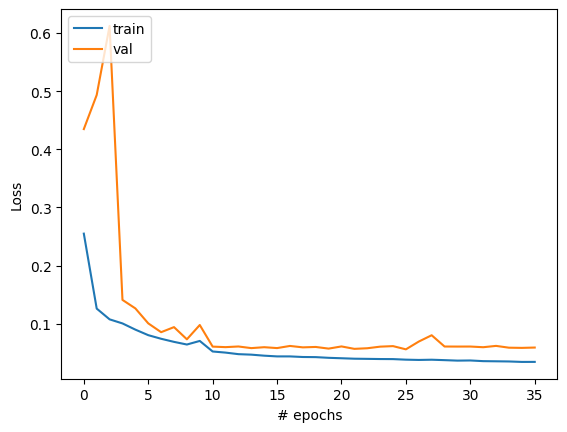

In [28]:
# plot loss vs epochs curve
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('# epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
# visualize prediction on single image

def visualize_pred(ind, images, landmarks):

    plt.figure(figsize=(5,5))

    # load an image
    img = images[ind].copy()
    img = np.expand_dims(img, axis = 0)
    plt.imshow(img[0][:,:,0], cmap='gray')

    land_pred = model.predict(img)


    # ground truth landmarks
    keypoints = landmarks[ind].copy().reshape(KEYPOINTS,2)
    keypoints[:,0] = keypoints[:,0] * h
    keypoints[:,1] = keypoints[:,1] * w
    plt.plot(keypoints[:,1], keypoints[:,0], 'go', markersize=3)
    # predicted landmarks
    keypointsT = land_pred[0].copy().reshape(KEYPOINTS,2)
    keypointsT[:,0] = keypointsT[:,0] * h
    keypointsT[:,1] = keypointsT[:,1] * w
    plt.plot(keypointsT[:,1], keypointsT[:,0], 'ro', markersize=3)

    plt.axis('off')

1/1 [==============================] - 1s 1s/step


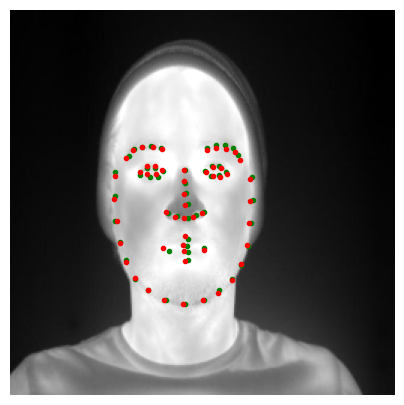

In [30]:
visualize_pred(8, img_train, l_train)

In [31]:
# visualize prediction on random ten images

def visualize_pred_rand(images, landmarks, gt=True):

    fig, axs = plt.subplots(2, 5, figsize=(15,6))
    plt.subplots_adjust(wspace=0, hspace=0.1)

    # selecting 10 random images from set
    indexes = np.random.randint(0,images.shape[0],10)
    img = images[indexes]
    land = landmarks[indexes]
    land_pred = model.predict(img)

    # iterate over images
    ind = 0

    for i in range(2):
        for j in range(5):

            # display image
            axs[i, j].imshow(img[ind][:,:,0], cmap='gray')

            # display predicted landmarks
            keypointsT = land_pred[ind].copy().reshape(KEYPOINTS,2)
            keypointsT[:,0] = keypointsT[:,0] * h
            keypointsT[:,1] = keypointsT[:,1] * w

            axs[i, j].plot(keypointsT[:,1], keypointsT[:,0], 'ro', markersize=2)

            # if gt is true, display ground truth landmarks
            if gt:
                keypoints = land[ind].copy().reshape(KEYPOINTS,2)
                keypoints[:,0] = keypoints[:,0] * h
                keypoints[:,1] = keypoints[:,1] * w
                axs[i, j].plot(keypoints[:,1], keypoints[:,0], 'go', markersize=2)

            # turn off axis display
            axs[i, j].axis('off')

            ind += 1

    # save figure
    plt.savefig("results.png")

1/1 [==============================] - 1s 504ms/step


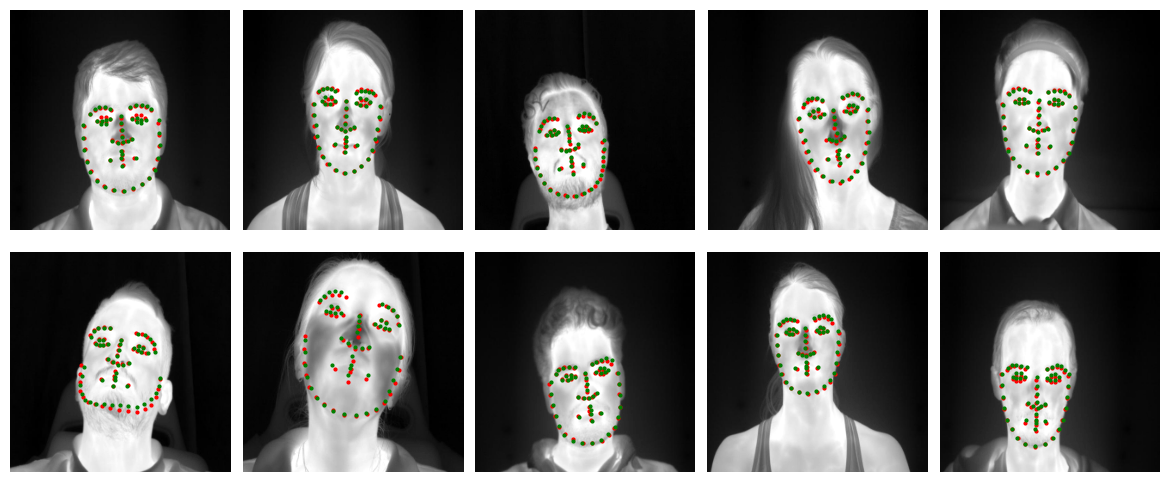

In [32]:
visualize_pred_rand(img_train, l_train)

1/1 [==============================] - 0s 27ms/step


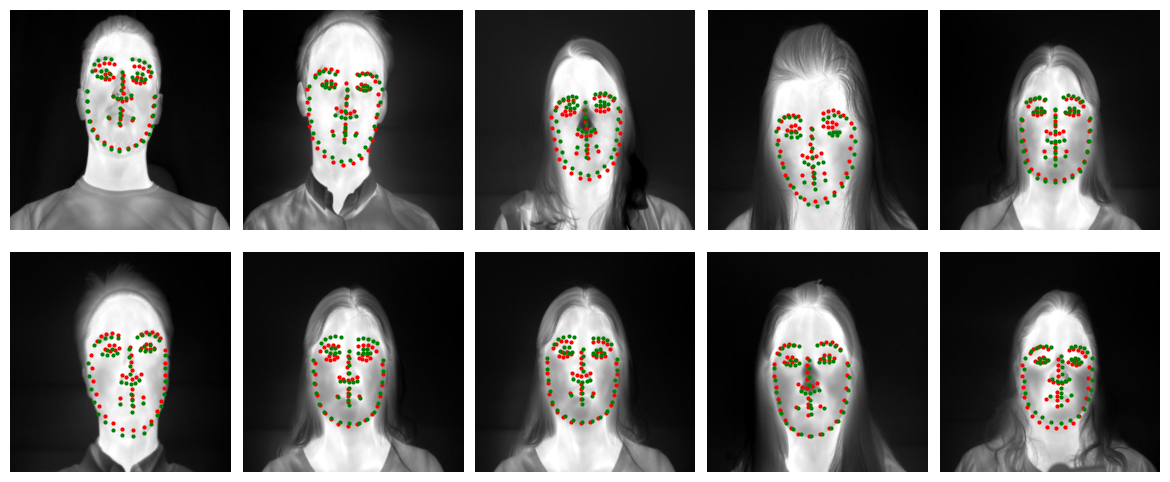

In [33]:
# visualize ten random predictions
visualize_pred_rand(img_test, l_test)

In [34]:
# normalized mean error

def NME(land, land_pred):

    N = land.shape[0]
    l = land.reshape(land.shape[:-1] + (KEYPOINTS,2))
    lt = land_pred.reshape(land_pred.shape[:-1] + (KEYPOINTS,2))

    # error for one sample
    nme = (np.sum(np.sqrt(np.sum((l - lt)**2, axis=2)), axis=1)
                            / np.sqrt(np.sum((l[:,45] - l[:,36])**2, axis=1))) / KEYPOINTS

    # average over the whole sample
    nme_avg = np.sum(nme) / N

    return nme_avg

In [35]:
# predicting landmarks
l_test_pred = model.predict(img_test)
l_train_pred = model.predict(img_train)
l_val_pred = model.predict(img_val)

# evaluating NME of predictions
print("Normalized Mean Error on training set: ", NME(l_train, l_train_pred))
print("Normalized Mean Error on validation set: ", NME(l_val, l_val_pred))
print("Normalized Mean Error on testing set: ", NME(l_test, l_test_pred))

47/47 [==============================] - 3s 54ms/step
Normalized Mean Error on training set:  0.0369106897321696
Normalized Mean Error on validation set:  0.09161990155052362
Normalized Mean Error on testing set:  0.09496016938962881


In [36]:
# calculate Mean Absolute Error

def MAE(l, l_pred):

    mae = keras.losses.mean_absolute_error(l, l_pred)

    return np.mean(tf.Session().run(mae))

In [ ]:
# predicting landmarks
l_train_pred = model.predict(img_train)
l_val_pred = model.predict(img_val)
l_test_pred = model.predict(img_test)
#l_test_aa_pred = model_full.predict(img_aachen)

In [4]:
# evaluating NME of predictions
#print("Normalized Mean Error on training set: ", NME(l_train, l_train_pred))
#print("Normalized Mean Error on validation set: ", NME(l_val, l_val_pred))
#print("Normalized Mean Error on testing set: ", NME(l_test, l_test_pred))
#print("Normalized Mean Error on RWTH-Aachen: ", NME(l_aachen, l_test_aa_pred))

# evaluating MAE of predictions
#print("Mean Absolute Error on training set: ", MAE(l_train, l_train_pred))
#print("Mean Absolute Error on validation set: ", MAE(l_val, l_val_pred))
#print("Mean Absolute Error on testing set: ", MAE(l_test, l_test_pred))
#print("Mean Absolute Error on RWTH-Aachen: ", MAE(l_aachen, l_test_aa_pred))

In [ ]:
# save weights
model.save('/thermal/MyDrive/dataset/model.h5')
print("Model size (KB): ", os.path.getsize('model.h5')/1000)